Processing DIWater_02_R3_FKS50_20250421_C01.mpt
Saved data table to: DIWater_02_R3_FKS50_20250421_C01_points.csv


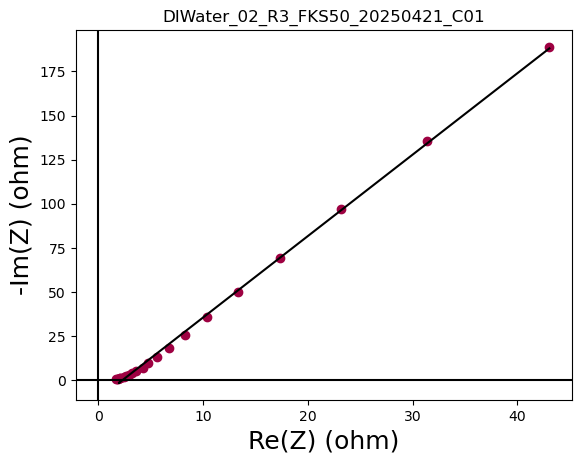

Processing DIWater_02_R2_FKS50_20250421_C01.mpt
Saved data table to: DIWater_02_R2_FKS50_20250421_C01_points.csv


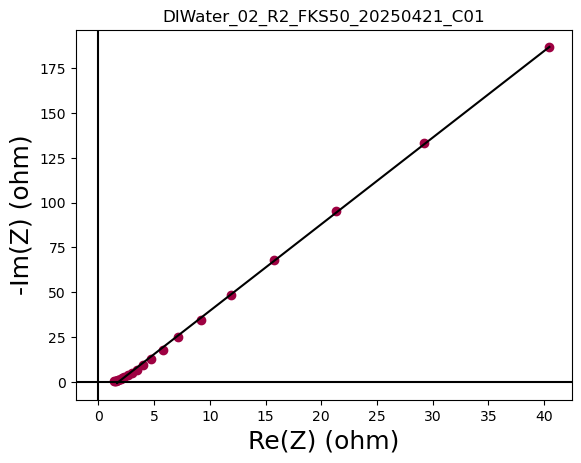

Processing DIWater_02_R1_FKS50_20250421_C01.mpt
Saved data table to: DIWater_02_R1_FKS50_20250421_C01_points.csv


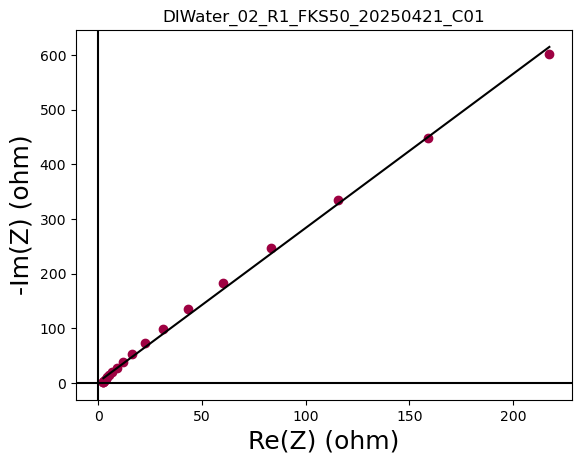

Processing DIWater_01_R3_FKS50_20250421_C01.mpt
Saved data table to: DIWater_01_R3_FKS50_20250421_C01_points.csv


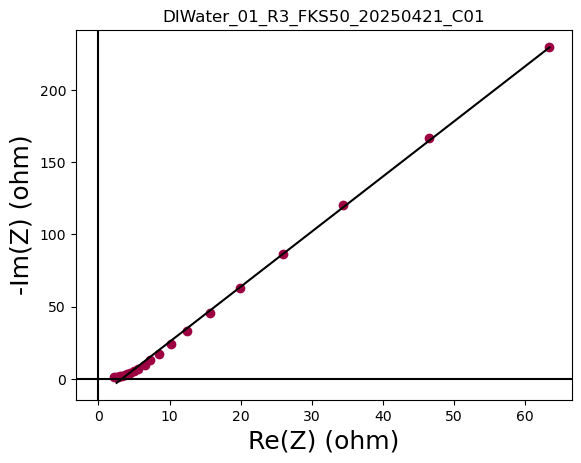

Processing DIWater_03_R1_FKS50_20250421_C01.mpt
Saved data table to: DIWater_03_R1_FKS50_20250421_C01_points.csv


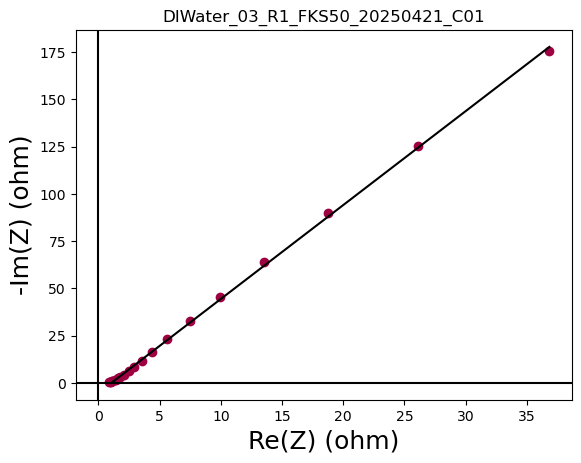

Processing DIWater_03_R2_FKS50_20250421_C01.mpt
Saved data table to: DIWater_03_R2_FKS50_20250421_C01_points.csv


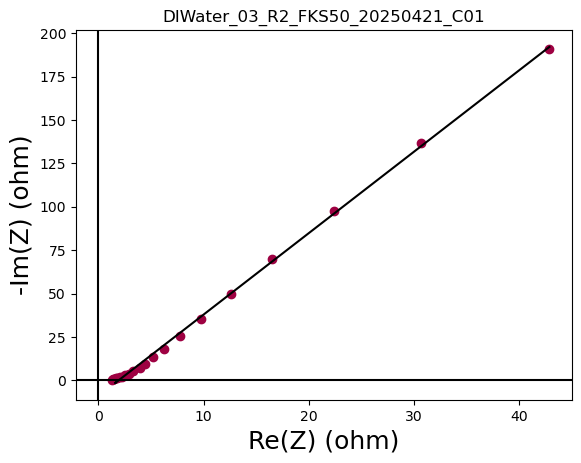

Processing DIWater_03_R3_FKS50_20250421_C01.mpt
Saved data table to: DIWater_03_R3_FKS50_20250421_C01_points.csv


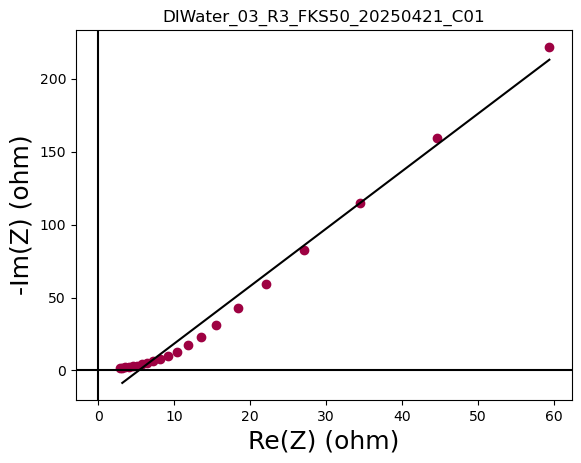

Processing DIWater_01_R1_FKS50_20250421_C01.mpt
Saved data table to: DIWater_01_R1_FKS50_20250421_C01_points.csv


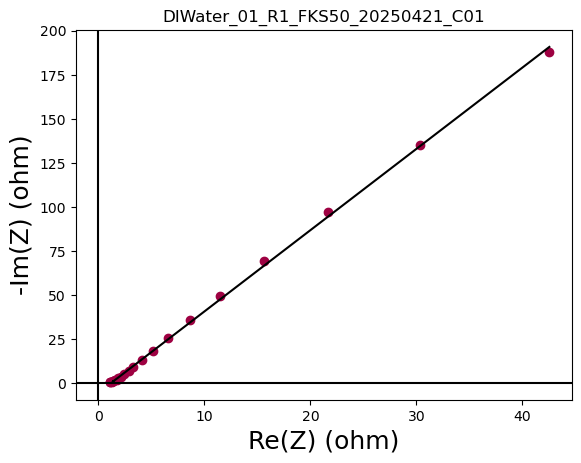

Processing DIWater_01_R2_FKS50_20250421_C01.mpt
Saved data table to: DIWater_01_R2_FKS50_20250421_C01_points.csv


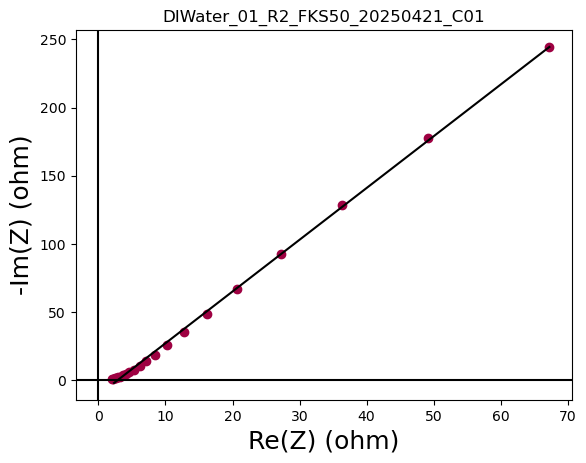

                               filename  real intercept
0  DIWater_02_R3_FKS50_20250421_C01.mpt        2.290044
1  DIWater_02_R2_FKS50_20250421_C01.mpt        1.803997
2  DIWater_02_R1_FKS50_20250421_C01.mpt       -0.698977
3  DIWater_01_R3_FKS50_20250421_C01.mpt        3.279020
4  DIWater_03_R1_FKS50_20250421_C01.mpt        1.056807
5  DIWater_03_R2_FKS50_20250421_C01.mpt        1.910688
6  DIWater_03_R3_FKS50_20250421_C01.mpt        5.309363
7  DIWater_01_R1_FKS50_20250421_C01.mpt        1.203503
8  DIWater_01_R2_FKS50_20250421_C01.mpt        2.881363


In [ ]:
import matplotlib.pyplot as plt 
from pathlib import Path
import pandas as pd
import numpy as np

from glitch.impedance import EISSpectrumDoc, nyquist_plot, SingleSpectrum
from pathlib import Path

data_folder = Path("/Users/andreakowal/Downloads/MTRON/DI Water").expanduser() #folder path

#background correction files (constant across all)
OC_path = Path("/Users/andreakowal/Downloads/MTRON/02_07_25_OCTest_C01.mpt").expanduser()
SC_path = Path("/Users/andreakowal/Downloads/MTRON/02_03_25_SCTest_C01.mpt").expanduser()
oc = EISSpectrumDoc.from_eclab_mpt(OC_path)
sc = EISSpectrumDoc.from_eclab_mpt(SC_path)

nyquist_results = []
trendline_results = []

#tredline intercept
def trendline_intercept(Z_real, Z_imag):
    slope, intercept = np.polyfit(Z_real, Z_imag, 1)
    return -intercept/slope

#for loop to read all .mpt files in folder
for file_path in data_folder.glob("*.mpt"):
    print(f"Processing {file_path.name}")

    #Create EISSpectrumDoc
    my_spectrum = EISSpectrumDoc.from_eclab_mpt(file_path)

    #Apply background correction
    my_spectrum.background_correct(oc.cycles_raw[0], sc.cycles_raw[0])

    #Filter out frequencies above 250 kHz
    raw_data = my_spectrum.cycles_raw[0]
    mask = raw_data.frequencies <= 250_000 #define frequency limit
    freqs_filtered = raw_data.frequencies[mask]
    impedance_filtered = raw_data.impedance[mask]

    #Create data table for Z_real, Z_imag, and frequencies
    Z_real = impedance_filtered.real
    Z_imag = impedance_filtered.imag
    df_points = pd.DataFrame({"Freqency(Hz)": freqs_filtered, "Z_real (Ohm)": Z_real, "Z_imag (Ohm)": Z_imag}) #join data froms for each file?, look up pandas averaging functions
    output_filename = f"{file_path.stem}_points.csv"
    df_points.to_csv(output_filename, index = False)
    print(f"Saved data table to: {output_filename}")

    #Plot Nyquist (with filtered out frequencies)
    fig, ax = plt.subplots()
    nyquist_plot(spectra = [my_spectrum], ax = ax, freq_limit = (0, 250000), plot_uncorrected = False)
    ax.set_title(file_path.stem)
    trendline = np.poly1d(np.polyfit(Z_real, Z_imag, 1))
    plt.plot(Z_real, trendline(Z_real), color ="black")
    plt.show()

    #Spectrum of corrected and filtered data
    filtered_cycle = SingleSpectrum (frequencies = freqs_filtered, impedance = impedance_filtered)
    filtered_doc = EISSpectrumDoc(cycles=[filtered_cycle])

    #Get real x-intercept
    #intercept = filtered_doc.real_intercept(tol = 0.15)
    x_intercept = trendline_intercept(Z_real, Z_imag)

    #Save results
    nyquist_results.append({"filename": file_path.name, "real intercept": x_intercept})

#Create summary table of data file and x-intercepts
df = pd.DataFrame(nyquist_results)
df.to_csv("EIS_summary.csv", index = False)
print(df)
